Kagle Api

In [ ]:
from google.colab import files
files.upload()

DataSet Donwload


In [17]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ai4a-lab/comprehensive-soil-classification-datasets
!unzip comprehensive-soil-classification-datasets.zip
print("Done")

Streaming output truncated to the last 5000 lines.
  inflating: CyAUG-Dataset/Black_Soil/b (1054).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1055).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1056).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1057).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1058).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1059).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1060).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1061).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1062).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1063).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1064).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1065).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1066).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1067).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1068).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1069).jpeg  
  inflating: CyAUG-Dataset/Black_Soil/b (1070).jpeg  
  inflating: CyAUG-Dataset/Blac

Library Imports

In [18]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from skimage import io
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, datasets, utils

Settings for reproducibility

In [19]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Gpu Verification

In [20]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


DataSet preparing

In [21]:
import glob

# 1. Define the path to the root dataset directory.
data_dir = '/content/Orignal-Dataset'

# 2. Define the glob pattern to find all .jpg files inside the class subfolders.
# The '/*/' part matches any immediate sub-directory (the class folders).
# The '/*.jpg' part matches any file ending with .jpg within those sub-directories.
path_list = glob.glob(data_dir + '/*/*.jpg')


In [22]:
label_list = []
for path in path_list:
    # Split the path into directory (head) and filename (tail).
    # e.g., head='/content/Orignal-Dataset/Alluvial_Soil', tail='1.jpg'
    head, tail = os.path.split(path)

    # Get the base name of the directory (which is the class name).
    # e.g., 'Alluvial_Soil'
    label = os.path.basename(head)
    label_list.append(label)


In [23]:
# 1. Get unique class names from the label list.
class_names = sorted(list(set(label_list)))
n_classes = len(class_names)
print(f"\nTotal classes found: {n_classes}")
print(class_names)

# 2. Create the class-to-index mapping dictionary.
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
print("\nMapping (class_to_idx):")
print(class_to_idx)

# 3. Convert the text label_list to a numeric list (label_list_idx).
label_list_idx = [class_to_idx[label] for label in label_list]
print("\nExample of label_list (as numbers):")
print(label_list_idx[:5])


Total classes found: 7
['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']

Mapping (class_to_idx):
{'Alluvial_Soil': 0, 'Arid_Soil': 1, 'Black_Soil': 2, 'Laterite_Soil': 3, 'Mountain_Soil': 4, 'Red_Soil': 5, 'Yellow_Soil': 6}

Example of label_list (as numbers):
[0, 0, 0, 0, 0]


Hold out

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# ----------------------------------------------------
# HOLD-OUT STRATEGY (2-step split)
# ----------------------------------------------------

# 1. First split: Separate 20% of the data for the Test set.
# 'path_list' is from glob, 'label_list_idx' is the numeric list.
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    path_list,
    label_list_idx,
    test_size=0.2, # 20% of total data for testing
    stratify=label_list_idx, # Ensures balanced classes in the split
    random_state=42
)

# 2. Second split: Split the remaining 80% (train_val_paths) into Train and Validation.
#
# test_size=0.25 here means 25% of the remaining 80%.
# This results in:
# 60% Train (0.75 * 0.80)
# 20% Validation (0.25 * 0.80)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.25,
    stratify=train_val_labels,
    random_state=42
)

# ----------------------------------------------------
# VERIFY SPLIT SIZES
# ----------------------------------------------------
print(f"Total training images: {len(train_paths)}")
print(f"Total validation images: {len(val_paths)}")
print(f"Total testing images: {len(test_paths)}")

Total training images: 711
Total validation images: 237
Total testing images: 238


Padronization of the datasets

In [25]:
data_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Classe

In [26]:
class SoilDataset(Dataset):
    """
    Custom Dataset for loading soil images from a path list.
    """
    def __init__(self, path_list, label_list, transform=None):
        """
        Args:
            path_list (list): List of all image file paths.
            label_list (list): List of corresponding labels (as integers).
            transform (torchvision.transforms, optional): Transformations to apply.
        """
        self.path_list = path_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.path_list)

    def __getitem__(self, idx):
        """
        Gets one item from the dataset.

        Args:
            idx (int): The index of the item.

        Returns:
            tuple: (image, label)
        """
        # 1. Get the image path and label for the given index
        img_path = self.path_list[idx]
        label = self.label_list[idx]

        # 2. Open the image using PIL and convert to RGB
        # (Converts (grayscale) or (RGBA) images to standard 3-channel RGB)
        image = Image.open(img_path).convert('RGB')

        # 3. Apply transformations, if any
        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
# --- 1. Instantiate the Datasets ---
train_dataset = SoilDataset(train_paths, train_labels, transform=data_transforms_train)
val_dataset = SoilDataset(val_paths, val_labels, transform=data_transforms_test)
test_dataset = SoilDataset(test_paths, test_labels, transform=data_transforms_test)

# --- 2. Define Hyperparameters ---
# Define the batch size (you can tune this hyperparameter later)
BATCH_SIZE = 32

NUM_WORKERS = 2

# --- 3. Create the DataLoaders ---
# The 'shuffle=True' for the training loader is very important.
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

# Shuffle is set to False for validation and testing.
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# --- 4. Verification ---
print("DataLoaders created successfully.")
print(f"Train batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

DataLoaders created successfully.
Train batches: 23
Validation batches: 8
Test batches: 8


AlexNet

In [28]:
model_alexnet = models.alexnet(pretrained=True)

print(model_alexnet)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 198MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
# Freeze all parameters in the 'features' section
for param in model_alexnet.features.parameters():
    param.requires_grad = False

Modifying for 7 classes

In [30]:
# Get the number of input features for the classifier's last layer
num_ftrs = model_alexnet.classifier[6].in_features

# Replace the last layer with a new one for your 7 classes
model_alexnet.classifier[6] = nn.Linear(num_ftrs, n_classes) # n_classes = 7

# Move the model to the GPU (if available)
model_alexnet = model_alexnet.to(DEVICE)

print(model_alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Alex Hyperparams

In [31]:
# Hyperparameters
N_EPOCHS = 50      # (Number of epochs to train)
LR = 0.0001         # (Learning Rate)
MOMENTUM = 0.9

# 1. Loss Function (Criterion)
criterion = nn.CrossEntropyLoss()

# 2. Optimizer
# We only want to optimize the parameters of the new layer we added
optimizer_alexnet = optim.SGD(
    model_alexnet.classifier[6].parameters(), # Only pass the new layer's params
    lr=LR,
    momentum=MOMENTUM
)

Training

In [32]:
import time
import copy

def train_model(model, model_name, criterion, optimizer,
                dataloaders, n_epochs=5, exp_path='./'):

    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the correct dataloader for the phase
            dataloader = dataloaders[phase]
            dataset_size = len(dataloader.dataset)

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['lr'].append(optimizer.param_groups[0]['lr'])
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                torch.save(model.state_dict(),
                           f'{exp_path}/best_model_{model_name}.pt')


    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [33]:
# 1. Create a dictionary for your dataloaders
dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}

# 2. Create an 'exp' folder to save the best model
import os
EXP_PATH = './exp_alexnet/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

In [34]:
print("Starting AlexNet training...")

# Call the train function
model_alexnet, history_alexnet = train_model(
    model_alexnet,
    'alexnet_soil',
    criterion,
    optimizer_alexnet,
    dataloaders_dict,
    n_epochs=N_EPOCHS,
    exp_path=EXP_PATH
)

print("Training finished!")

Starting AlexNet training...
Epoch 1/50
----------
train Loss: 1.5624 Acc: 0.4459
val Loss: 1.0922 Acc: 0.7342
Epoch 2/50
----------
train Loss: 0.9567 Acc: 0.7145
val Loss: 0.7626 Acc: 0.7722
Epoch 3/50
----------
train Loss: 0.7726 Acc: 0.7764
val Loss: 0.6383 Acc: 0.7975
Epoch 4/50
----------
train Loss: 0.6704 Acc: 0.7876
val Loss: 0.5646 Acc: 0.8228
Epoch 5/50
----------
train Loss: 0.6088 Acc: 0.8087
val Loss: 0.5213 Acc: 0.8228
Epoch 6/50
----------
train Loss: 0.6014 Acc: 0.8059
val Loss: 0.4902 Acc: 0.8397
Epoch 7/50
----------
train Loss: 0.5444 Acc: 0.8270
val Loss: 0.4649 Acc: 0.8439
Epoch 8/50
----------
train Loss: 0.5101 Acc: 0.8397
val Loss: 0.4457 Acc: 0.8565
Epoch 9/50
----------
train Loss: 0.5109 Acc: 0.8298
val Loss: 0.4314 Acc: 0.8608
Epoch 10/50
----------
train Loss: 0.4850 Acc: 0.8425
val Loss: 0.4162 Acc: 0.8692
Epoch 11/50
----------
train Loss: 0.4693 Acc: 0.8594
val Loss: 0.4045 Acc: 0.8692
Epoch 12/50
----------
train Loss: 0.4767 Acc: 0.8383
val Loss: 0.3

Graphs

In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Plota os gráficos de Loss, Accuracy e Learning Rate a partir de
    um objeto 'history' do treinamento.
    """

    # --- Extrai os dados do histórico ---
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    lr_history = history['lr']

    # Pega o número de épocas
    n_epochs = len(train_loss)
    epochs = range(n_epochs)

    # --- Configura a Figura com 3 Subplots ---
    # Define o tamanho total da figura (largura, altura)
    # Aumentamos a altura (ex: 15) para acomodar os 3 gráficos
    plt.figure(figsize=(8, 15))

    # --- 1. Gráfico de Loss ---
    plt.subplot(3, 1, 1) # (3 linhas, 1 coluna, 1º gráfico)
    plt.title(f"Loss - {n_epochs} epochs")
    plt.plot(epochs, train_loss, 'magenta', label='Train. loss')
    plt.plot(epochs, val_loss, 'green', label='Val. loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # --- 2. Gráfico de Accuracy ---
    plt.subplot(3, 1, 2) # (3 linhas, 1 coluna, 2º gráfico)
    plt.title(f"Accuracy - {n_epochs} epochs")
    plt.plot(epochs, train_acc, 'magenta', label='Train accuracy')
    plt.plot(epochs, val_acc, 'green', label='Val. accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # --- 3. Gráfico de Learning Rate ---
    plt.subplot(3, 1, 3) # (3 linhas, 1 coluna, 3º gráfico)
    plt.title(f"Learning rate - {n_epochs} epochs")
    plt.plot(epochs, lr_history, 'magenta', label='Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('LR')
    plt.legend()

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

Alex Evaluation

In [36]:
# 1. Ensure the model is in evaluation mode
model_alexnet.eval()

# 2. Create lists to store predictions and true labels
y_pred = []
y_true = []

# 3. Loop through the test_dataloader
# (No gradients are needed, so 'torch.no_grad()' is used for efficiency)
with torch.no_grad():
    for inputs, labels in test_dataloader:
        # Move data to the device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Get model outputs
        outputs = model_alexnet(inputs)

        # Get the prediction (the class with the highest score)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        # (Move data back to CPU to store in numpy/python lists)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Evaluation on Test Set Complete!")

Evaluation on Test Set Complete!


Overall Test Accuracy: 0.8655

Classification Report:
               precision    recall  f1-score   support

Alluvial_Soil       0.50      0.30      0.38        10
    Arid_Soil       0.85      0.77      0.81        57
   Black_Soil       0.96      1.00      0.98        51
Laterite_Soil       0.82      0.93      0.87        44
Mountain_Soil       0.86      0.90      0.88        40
     Red_Soil       0.86      0.86      0.86        22
  Yellow_Soil       0.92      0.86      0.89        14

     accuracy                           0.87       238
    macro avg       0.82      0.80      0.81       238
 weighted avg       0.86      0.87      0.86       238


Generating confusion matrix plot...
Confusion matrix plot saved as 'confusion_matrix.png'


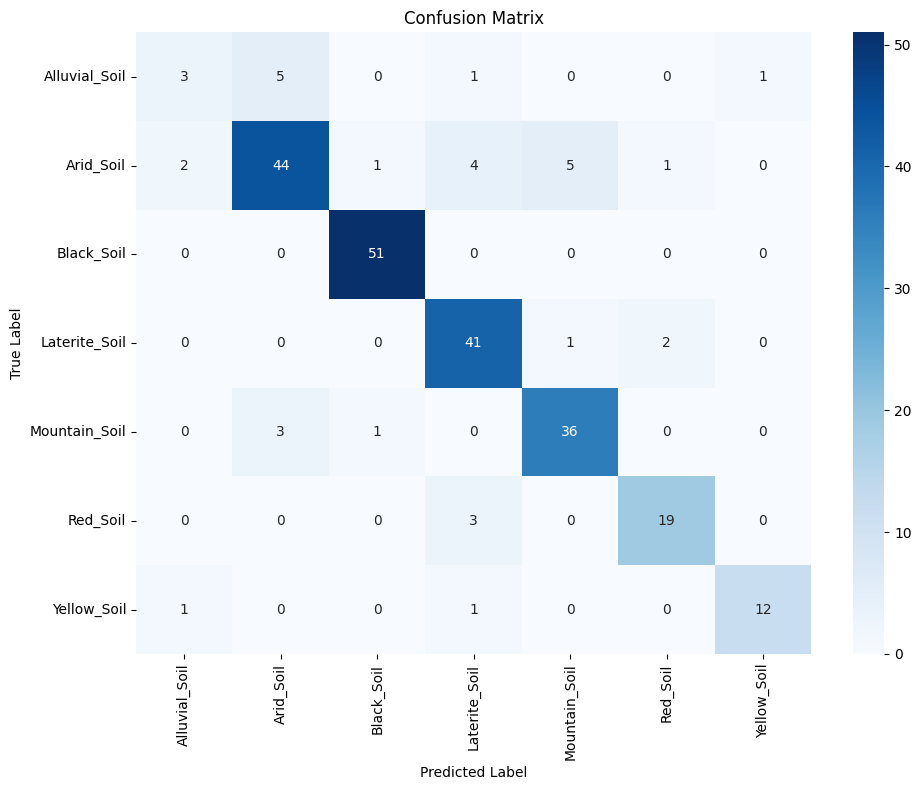

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Assuming 'y_true', 'y_pred', and 'class_names' ---
# --- already exist (from your notebook) ---

# 1. Get Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Test Accuracy: {accuracy:.4f}\n")

# 2. Get Precision, Recall, and F1-score
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# 3. Get Confusion Matrix (Calculation)
cm = confusion_matrix(y_true, y_pred)

# 4. MODIFICATION: Generate and Save the Confusion Matrix as a PNG
print("\nGenerating confusion matrix plot...")

try:
    # Create the figure
    plt.figure(figsize=(10, 8)) # Adjust the size as needed

    # Use Seaborn to create the heatmap
    sns.heatmap(cm,
                annot=True,     # Show the numbers inside the cells
                fmt='d',        # Format the numbers as integers
                cmap='Blues',   # Color scheme
                xticklabels=class_names,
                yticklabels=class_names)

    # Add titles and labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save the figure as a PNG
    plt.savefig('confusion_matrix.png')

    print("Confusion matrix plot saved as 'confusion_matrix.png'")

except ImportError:
    print("\nError: The 'seaborn' library is not installed.")
    print("Please install it with: pip install seaborn")
except Exception as e:
    print(f"\nAn error occurred while generating the plot: {e}")

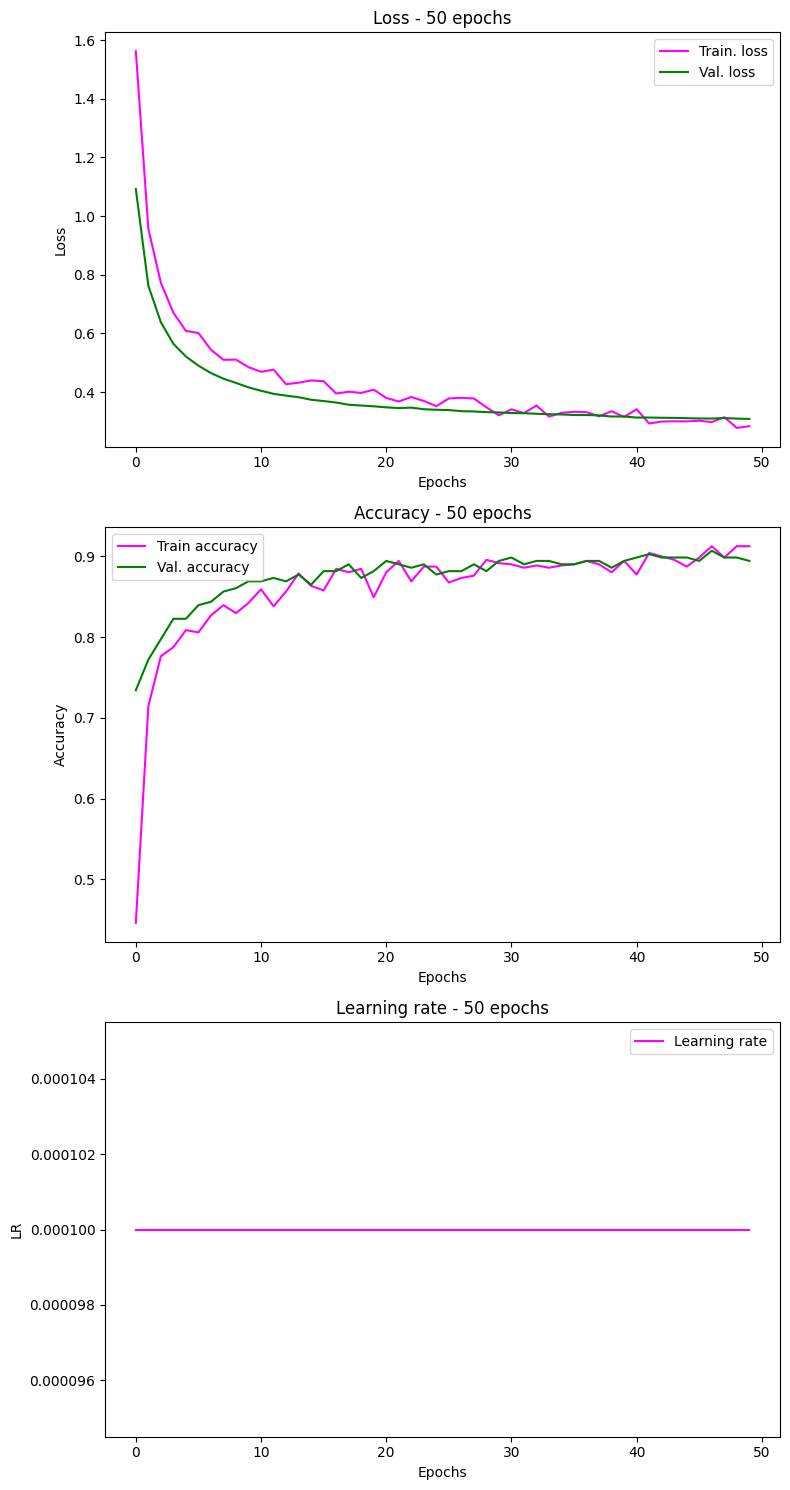

In [38]:
plot_history(history_alexnet)

Resnet18

In [39]:
# Load the pre-trained ResNet-18 model
model_resnet = models.resnet18(pretrained=True)

# Freeze all parameters in the model
for param in model_resnet.parameters():
    param.requires_grad = False

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [40]:
# Get the number of input features for the 'fc' layer
num_ftrs = model_resnet.fc.in_features

# (n_classes = 7)
model_resnet.fc = nn.Linear(num_ftrs, n_classes)

# Move the model to the GPU
model_resnet = model_resnet.to(DEVICE)

print("ResNet-18 model adapted:")
print(model_resnet.fc) # (Shows your new layer)

ResNet-18 model adapted:
Linear(in_features=512, out_features=7, bias=True)


In [41]:
# We only pass the parameters of the new (unfrozen) final layer
optimizer_resnet = optim.SGD(
    model_resnet.fc.parameters(),
    lr=LR,
    momentum=MOMENTUM
)

In [ ]:
Train using Resnet18

In [42]:
# Create a new experiment path for this model
EXP_PATH_RESNET = './exp_resnet/'
if not os.path.exists(EXP_PATH_RESNET):
    os.makedirs(EXP_PATH_RESNET)

print("\nStarting ResNet-18 training...")

# Call the train function
model_resnet, history_resnet = train_model(
    model_resnet,
    'resnet18_soil',
    criterion,
    optimizer_resnet,
    dataloaders_dict,
    n_epochs=N_EPOCHS,
    exp_path=EXP_PATH_RESNET
)

print("ResNet-18 training finished!")


Starting ResNet-18 training...
Epoch 1/50
----------
train Loss: 2.0644 Acc: 0.1392
val Loss: 1.7787 Acc: 0.2954
Epoch 2/50
----------
train Loss: 1.7331 Acc: 0.3193
val Loss: 1.6349 Acc: 0.3544
Epoch 3/50
----------
train Loss: 1.6335 Acc: 0.3741
val Loss: 1.5700 Acc: 0.4219
Epoch 4/50
----------
train Loss: 1.5681 Acc: 0.4360
val Loss: 1.4923 Acc: 0.4726
Epoch 5/50
----------
train Loss: 1.5125 Acc: 0.4838
val Loss: 1.4355 Acc: 0.5232
Epoch 6/50
----------
train Loss: 1.4415 Acc: 0.5359
val Loss: 1.3707 Acc: 0.5865
Epoch 7/50
----------
train Loss: 1.4137 Acc: 0.5387
val Loss: 1.3274 Acc: 0.5865
Epoch 8/50
----------
train Loss: 1.3516 Acc: 0.5781
val Loss: 1.2742 Acc: 0.6203
Epoch 9/50
----------
train Loss: 1.3159 Acc: 0.6188
val Loss: 1.2319 Acc: 0.6456
Epoch 10/50
----------
train Loss: 1.2583 Acc: 0.6357
val Loss: 1.1947 Acc: 0.6329
Epoch 11/50
----------
train Loss: 1.2177 Acc: 0.6385
val Loss: 1.1640 Acc: 0.6667
Epoch 12/50
----------
train Loss: 1.1795 Acc: 0.6624
val Loss: 

Resnet Evaluation


--- Evaluating ResNet-18 on Test Set ---
ResNet-18 Test Accuracy: 0.8235

ResNet-18 Classification Report:
               precision    recall  f1-score   support

Alluvial_Soil       0.00      0.00      0.00        10
    Arid_Soil       0.87      0.82      0.85        57
   Black_Soil       0.96      1.00      0.98        51
Laterite_Soil       0.72      0.75      0.73        44
Mountain_Soil       0.76      0.95      0.84        40
     Red_Soil       0.74      0.91      0.82        22
  Yellow_Soil       0.88      0.50      0.64        14

     accuracy                           0.82       238
    macro avg       0.70      0.70      0.69       238
 weighted avg       0.79      0.82      0.80       238

ResNet-18 Confusion Matrix:
[[ 0  2  0  2  4  1  1]
 [ 0 47  1  5  4  0  0]
 [ 0  0 51  0  0  0  0]
 [ 0  2  1 33  3  5  0]
 [ 0  2  0  0 38  0  0]
 [ 0  0  0  2  0 20  0]
 [ 0  1  0  4  1  1  7]]

Generating confusion matrix plot...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix plot saved as 'MatrizResNet.png'


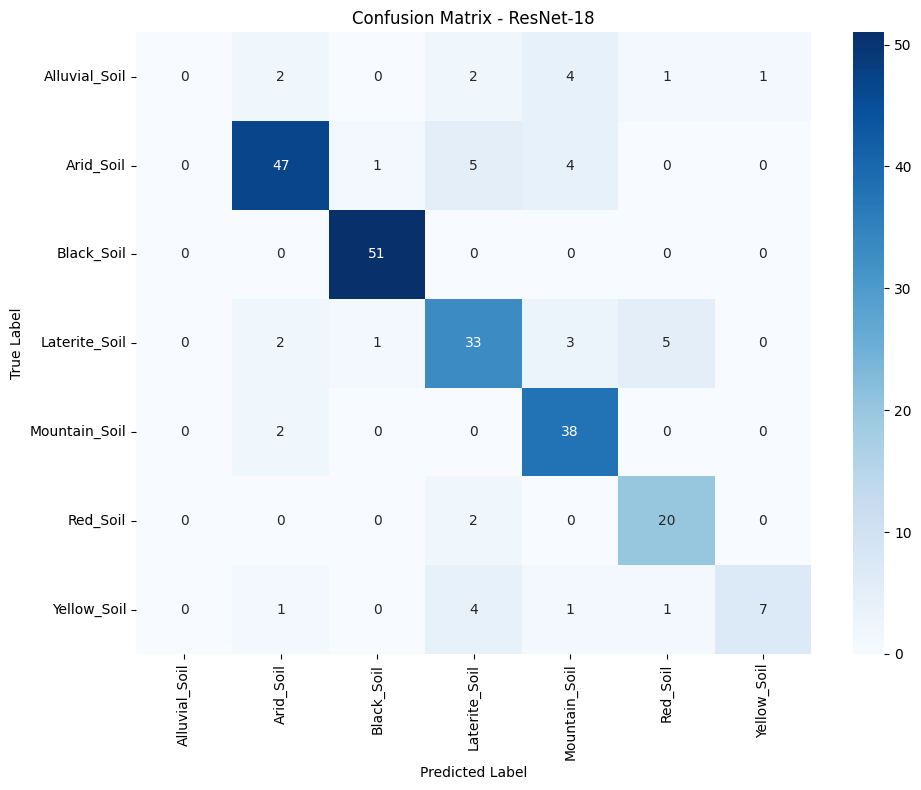

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\n--- Evaluating ResNet-18 on Test Set ---")

model_resnet.eval()

y_pred_resnet = []
y_true_resnet = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_resnet(inputs)
        _, preds = torch.max(outputs, 1)

        y_pred_resnet.extend(preds.cpu().numpy())
        y_true_resnet.extend(labels.cpu().numpy())

# 1. Accuracy
accuracy_resnet = accuracy_score(y_true_resnet, y_pred_resnet)
print(f"ResNet-18 Test Accuracy: {accuracy_resnet:.4f}\n")

# 2. Classification Report
print("ResNet-18 Classification Report:")
report_resnet = classification_report(y_true_resnet, y_pred_resnet, target_names=class_names)
print(report_resnet)

# 3. Confusion Matrix
print("ResNet-18 Confusion Matrix:")
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
print(cm_resnet)

# 4. Plot and Save Confusion Matrix
print("\nGenerating confusion matrix plot...")

try:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_resnet,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title('Confusion Matrix - ResNet-18')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    plt.savefig('MatrizResNet.png')
    print("Confusion matrix plot saved as 'MatrizResNet.png'")

except ImportError:
    print("\nError: The 'seaborn' library is not installed.")
    print("Please install it with: pip install seaborn")
except Exception as e:
    print(f"\nAn error occurred while generating the plot: {e}")


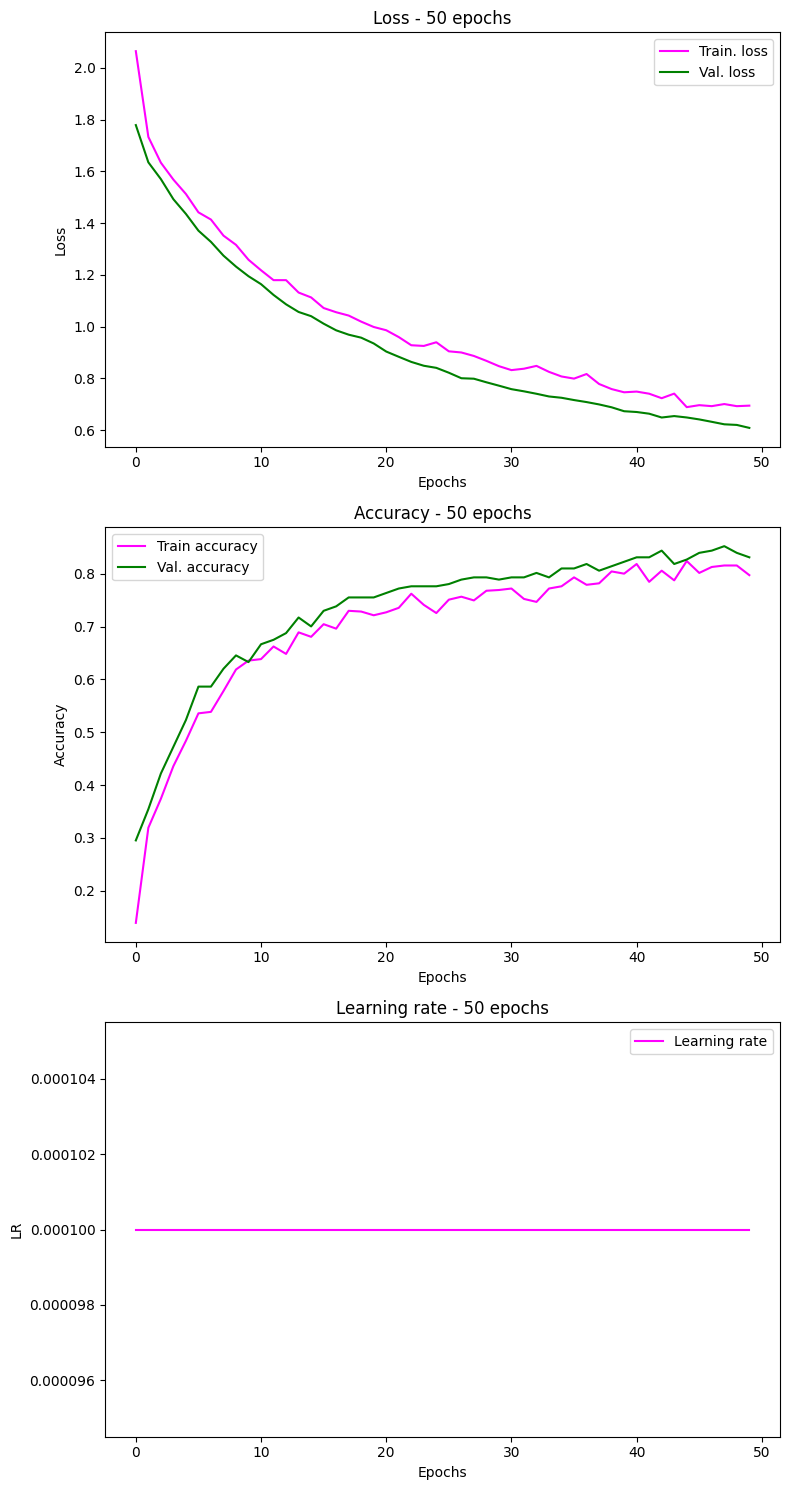

In [44]:
plot_history(history_resnet)